In [284]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T
trans = T.Compose([T.ToTensor(), T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])

import numpy as np
from scipy.spatial.distance import cdist
from scipy import stats

import cv2
from PIL import Image
from skimage.segmentation import slic
from skimage import io

import os
import sys
sys.path.insert(0, '/media/allen/mass/pytorch_Realtime_Multi-Person_Pose_Estimation/')
from network.rtpose_vgg import get_model
from network.post import decode_pose, plot_pose
from training.datasets.coco_data.preprocessing import (inception_preprocess,
                                              rtpose_preprocess,
                                              ssd_preprocess, vgg_preprocess)



In [ ]:
(0-'nose'	1-'neck' 
2-'' 3-'right_elbow' 4-'right_wrist'
5-''  6-'left_elbow'  7-'left_wrist'  
8-'right_hip'      9-'right_knee'  10-'right_ankle'	
11-'left_hip'      12-'left_knee'  13-'left_ankle'
14-'right_eye'	   15-'left_eye'   
16-'right_ear'     17-'left_ear'

In [146]:
right_shoulder = 2
left_shoulder = 5
right_hip = 8
left_hip = 11
right_knee = 9
left_knee = 12
UPPER = [2, 5, 8, 11]
THIGH1 = [8, 9]
THIGH2 = [11, 12]

In [368]:
def load_pose_model():
    model = get_model('vgg19') 
    weight_name = '/media/allen/mass/pytorch_Realtime_Multi-Person_Pose_Estimation/network/pose_model_scratch.pth'
    checkpoint = torch.load(weight_name)
    model_dict = model.state_dict()
    ckpt = {k.replace("module.", ""): v for k, v in checkpoint.items() if k.replace("module.", "") in model_dict and torch.isnan(v).sum() == 0}
    model_dict.update(ckpt)
    model.load_state_dict(model_dict)
    model = model.cuda()
    # model.float()
    model.eval()
    return model

class COLORS():
    ALL = np.array([[int(b),int(g),int(r)] for b,g,r in product([0,255],repeat = 3)])
    def __init__(self):
        self.color_names = ['Black',
                            'Red',
                            'Green',
                            'Yellow',
                            'Blue',
                            'Magenta',
                            'Aqua',
                            'White']        
        self.color_np = [(int(b),int(g),int(r)) for b,g,r in product([0,255],repeat = 3)]
    def get_color(self, c):
        return self.color_names[c]
    def get_color_value(self, c):
        return self.color_np[c]

Color = COLORS()

def get_pose(model, img):    
    pil_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
    pil_img = Image.fromarray(pil_img)    
        
    batch_var = trans(pil_img).unsqueeze(0).cuda()
    with torch.no_grad():
        predicted_outputs, _ = model(batch_var)

    output1, output2 = predicted_outputs[-2], predicted_outputs[-1]
    heatmap = output2.cpu().data.numpy().transpose(0, 2, 3, 1)[0]
    paf = output1.cpu().data.numpy().transpose(0, 2, 3, 1)[0]

    real_shape = img.shape

    heatmap = cv2.resize(heatmap, None, fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
    heatmap = heatmap[0:real_shape[0], 0:real_shape[1], :]
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

    paf = cv2.resize(paf, None, fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
    paf = paf[0:real_shape[0], 0:real_shape[1], :]
    paf = cv2.resize(paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

    param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}
    candidate, subset = decode_pose(
        img, param, heatmap, paf)  
    
    return subset, candidate

def get_upper_color(orig, to_plot, person, candidate, plot=False, true_color=False):
    h, w = to_plot.shape[:2]
    upper_color = None
    lower_color = None
    if plot:
        to_plot_ = to_plot.copy()
    
    sample_color = []
    if (person[UPPER] > 0).sum() == len(UPPER):              

        x_coord1 = np.linspace(candidate[int(person[right_shoulder])][0], 
                              candidate[int(person[left_hip])][0], num=10).astype(int)
        y_coord1 = np.linspace(candidate[int(person[right_shoulder])][1], 
                              candidate[int(person[left_hip])][1], num=10).astype(int)
        x_coord2 = np.linspace(candidate[int(person[left_shoulder])][0], 
                              candidate[int(person[right_hip])][0], num=10).astype(int)
        y_coord2 = np.linspace(candidate[int(person[left_shoulder])][1], 
                              candidate[int(person[right_hip])][1], num=10).astype(int)
        
        for x, y in zip(x_coord1, y_coord1):
            sample_color.append(to_plot[y, x, :])
            if plot:
                cv2.circle(orig, (x,y), 1, (255,255,255), thickness=-1)
        for x, y in zip(x_coord2, y_coord2):
            sample_color.append(to_plot[y, x, :])
            if plot:
                cv2.circle(orig, (x,y), 1, (255,255,255), thickness=-1)
        samples = np.array(sample_color)
        if true_color:
            color = int(cdist(samples.mean(axis=0, keepdims=True), Color.ALL).argmin(axis=1))
            upper_color = Color.get_color(color)
            if plot:
                cv2.rectangle(orig, (0, 0), (w, int(h/2)), Color.get_color_value(color), 10) 
        else:
            dist = cdist(samples, Color.ALL).argmin(axis=1)
            mode = stats.mode(dist)[0][0]

            upper_color = Color.get_color(mode)
            if plot:
                cv2.rectangle(orig, (0, 0), (w, int(h/2)), Color.get_color_value(mode), 10) 

    sample_color = []
    if (person[THIGH1] > 0).sum() == len(THIGH1): 
        x_coord1 = np.linspace(candidate[int(person[right_hip])][0], 
                              candidate[int(person[right_knee])][0], num=10).astype(int)
        y_coord1 = np.linspace(candidate[int(person[right_hip])][1], 
                              candidate[int(person[right_knee])][1], num=10).astype(int)
        for x, y in zip(x_coord1, y_coord1):
            sample_color.append(to_plot[y, x, :])
            if plot:
                cv2.circle(orig, (x,y), 1, (255,255,255), thickness=-1)
    
    if (person[THIGH2] > 0).sum() == len(THIGH2): 
        x_coord1 = np.linspace(candidate[int(person[right_hip])][0], 
                              candidate[int(person[right_knee])][0], num=10).astype(int)
        y_coord1 = np.linspace(candidate[int(person[right_hip])][1], 
                              candidate[int(person[right_knee])][1], num=10).astype(int)
        for x, y in zip(x_coord1, y_coord1):
            sample_color.append(to_plot[y, x, :])
            if plot:
                cv2.circle(orig, (x,y), 1, (255,255,255), thickness=-1)
                
    if (person[THIGH1] > 0).sum() == len(THIGH1) or (person[THIGH2] > 0).sum() == len(THIGH2): 
        samples = np.array(sample_color)
        if true_color:
            color = int(cdist(samples.mean(axis=0, keepdims=True), Color.ALL).argmin(axis=1))
            lower_color = Color.get_color(color)
            if plot:
                cv2.rectangle(orig, (0, int(h/2)), (w, h), Color.get_color_value(color), 10)
        else:
            dist = cdist(samples, Color.ALL).argmin(axis=1)
            mode = stats.mode(dist)[0][0]
            lower_color = Color.get_color(mode)
            if plot:
                cv2.rectangle(orig, (0, int(h/2)), (w, h), Color.get_color_value(mode), 10)  
            
    return lower_color, upper_color, orig

def superpixelize(img, path):
    image = io.imread(path)
    segments = slic(img_as_float(image), n_segments=150,slic_zero=True)
    to_plot = img.copy()
    for v in np.unique(segments):
        # construct a mask for the segment so we can compute image
        # statistics for *only* the masked region
        for i in range(3):
            temp = to_plot[:,:,i]
            avg = temp[segments == v].mean()
            temp[segments == v] = avg
            to_plot[:,:,i] = temp
    return to_plot

In [30]:
model = load_pose_model()

Bulding VGG19


In [386]:
# path = "/media/allen/mass/reid/26th/bounding_box_test/001_c103s1_000269_04.jpg"
path = "/media/allen/mass/reid/sogo/bounding_box_train/9999_c1s1_5250_02.jpg"
img = cv2.imread(path)

Blue Blue


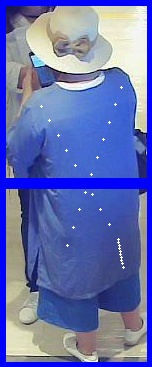

In [377]:
subset, candidate = get_pose(model, img)
to_plot = superpixelize(img, path)  
l, u, plot = get_upper_color(img, to_plot, subset[0], candidate, plot=True, true_color=True)
print(u, l)
temp = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
pil_img = Image.fromarray(temp)
pil_img

In [201]:
import os.path as osp

In [373]:
src = "/media/allen/mass/reid/sogo/bounding_box_train/"
dst = "/media/allen/mass/sogo_color_superpixel"
imgs_path = sorted([os.path.join(root, f) for root, _, files in os.walk(src) for f in files if '.jpg' in f or '.png' in f])

In [374]:
for path in imgs_path:
    img = cv2.imread(path)    
    subset, candidate = get_pose(model, img)
    to_plot = superpixelize(img, path)        
    l, u, plot = get_upper_color(img, to_plot, subset[0], candidate, plot=True)    
    path = osp.basename(path)
    if l is not None:
        if not osp.exists(osp.join(dst, 'lower', l)):
            os.makedirs(osp.join(dst, 'lower', l))
        cv2.imwrite(osp.join(dst, 'lower', l, path), plot)
    if u is not None:
        if not osp.exists(osp.join(dst, 'upper', u)):
            os.makedirs(osp.join(dst, 'upper', u))
        cv2.imwrite(osp.join(dst, 'upper', u, path), plot)
#     break

In [176]:
get_upper_color(img, subset[0], candidate, plot=True)

array([0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 4])

In [387]:
image = io.imread(path)
segments = slic(img_as_float(image), n_segments=150,slic_zero=True)
to_plot = img.copy()
for v in np.unique(segments):
    # construct a mask for the segment so we can compute image
    # statistics for *only* the masked region
    for i in range(3):
        temp = to_plot[:,:,i]
        avg = temp[segments == v].mean()
        temp[segments == v] = avg
        to_plot[:,:,i] = temp
    

In [280]:
subset, candidate = get_pose(model, img)
l, u, plot = get_upper_color(to_plot, subset[0], candidate, plot=True)

'blue'

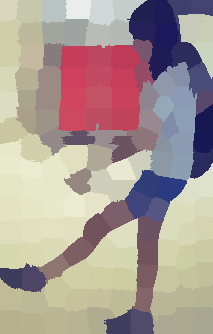

In [388]:
temp = cv2.cvtColor(to_plot, cv2.COLOR_BGR2RGB)    
pil_img = Image.fromarray(temp)
pil_img